# Data Exploratory: Wine

### Dependencies
Uncomment the cell below if your enviroment does not have the packages used installed.

In [1]:
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install seaborn
# %pip install numpy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Set seabor theme
sns.set_theme()

### Load dataset

In [3]:
# load data
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True, as_frame=True)

##### Take a look at the features ($X$) and the targets ($y$)

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

### Create data varibles that will store the results and scores of the models

In [6]:
results = {
    'Método': [],
    'Média': [],
    'Desvio Padrão': [],
    'Limite Inferior': [],
    'Limite Superior': []
}

all_scores = {}

### First Step
Implemented and test the non parametric models:
 + *ZeroR (ZR)*
 + *Gausssian Naive Bayes (GNB)*

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from scipy import stats

# Given the scores of the models compute some statics about it like
# mean, standard deviation and the superior and inferior support
def report(scores):
    mean = scores.mean()
    std = scores.std()
    inf, sup = stats.norm.interval(0.95, loc=mean,
                                  scale=std/np.sqrt(len(scores)))
    return (mean, std, inf, sup)

# Create cross val object
rpK = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

classifiers = [
    DummyClassifier(strategy='uniform'),
    GaussianNB()
]

name_class = [
    'ZR',
    'GNB'
]

# Begin training and test
for cls, name in zip(classifiers, name_class):
    # Create pipe
    steps = [
        ('scaler', StandardScaler()),
        ('estimator', cls)
    ]
    pipe = Pipeline(steps)

    # Execute the cross validation and prediction
    scores = cross_val_score(pipe, X, y, cv=rpK)
    all_scores[name] = scores
    stats_scores = report(scores)

    # Print the report of each classifier
    print(f"{name} : ")
    [print("{:.2f} ".format(n), end='') for n in stats_scores]
    print()

    # Update results
    results['Método'].append(name)
    results['Média'].append(stats_scores[0])
    results['Desvio Padrão'].append(stats_scores[1])
    results['Limite Inferior'].append(stats_scores[2])
    results['Limite Superior'].append(stats_scores[3])


ZR : 
0.34 0.13 0.30 0.39 
GNB : 
0.97 0.05 0.96 0.99 


### Second Step
Implemented and test the parametric models:
 + *K Nearest Neighbors (KNN)*
 + *Decision Tree (DT)*
 + *KMeans Centroids (KMC)*

##### Implements the new classifier KMC

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

class KMC(BaseEstimator, ClassifierMixin):

    def __init__(self, k=1):
        self.k = k
        self.centroids = np.array([])
        self.cent_labels = np.array([])

    # Train step
    def fit(self, X, y):
        for i, label in enumerate(np.unique(y)):
            labelX = X[y == label]  # Find the features of the class i
            kmeans = KMeans(n_clusters=self.k, random_state=36851234)
            kmeans.fit(labelX)  # Compute the centroids
            # Load the centroids found in class attribute
            if i == 0:
                self.centroids = kmeans.cluster_centers_
                self.cent_labels = np.ones(shape=kmeans.cluster_centers_.shape[0]) * label
            else:
                self.centroids = np.vstack((self.centroids, kmeans.cluster_centers_))
                self.cent_labels = np.concatenate((self.cent_labels, np.ones(shape=kmeans.cluster_centers_.shape[0]) * label))

    def predict(self, X_test):
        # Find the nearest neighbor of X_test relative to the centroid find in train step
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(self.centroids, self.cent_labels)
        return knn.predict(X_test)


#### Execute the classifiers

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
# Create genereal objects
# ---------------------
params = {
    'KNN': {'n_neighbors': [1, 3, 5, 7]},
    'DT': {'max_depth': [None, 3, 5, 10]},
    'KMC': {'k': [1, 3, 5, 7]}
}

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    KMC()
]

name_class = [
    'KNN',
    'DT',
    'KMC'
]

# Begin training and test
for clf, name in zip(classifiers, name_class):
    # Create pipeline
    grid_fold = StratifiedKFold(n_splits=4)
    gs = GridSearchCV(clf, param_grid=params[name], cv=grid_fold)
    steps = [
        ('scaler', StandardScaler()),
        ('estimator', gs)
    ]
    pipe = Pipeline(steps)

    # Execute cross validation with prediction
    scores = cross_val_score(pipe, X, y, cv=rpK)
    all_scores[name] = scores
    stats_scores = report(scores) # Compute the report

    # Print the stats report
    print(f"{name} : ")
    [print("{:.2f} ".format(n), end='') for n in stats_scores]
    print()

    # Update results
    results['Método'].append(name)
    results['Média'].append(stats_scores[0])
    results['Desvio Padrão'].append(stats_scores[1])
    results['Limite Inferior'].append(stats_scores[2])
    results['Limite Superior'].append(stats_scores[3])

KNN : 
0.95 0.06 0.93 0.97 
DT : 
0.89 0.07 0.87 0.92 
KMC : 
0.97 0.05 0.95 0.98 


### Save the statics of scores in a file

In [10]:
df_results = pd.DataFrame(results)
df_results.to_csv('./tables/results.csv', index=False, float_format='%.2f')
df_results.head()

,Método,Média,Desvio Padrão,Limite Inferior,Limite Superior
0,ZR,0.344662,0.126260,0.299481,0.389843
1,GNB,0.973420,0.048205,0.956171,0.990670
2,KNN,0.954793,0.055735,0.934849,0.974737
3,DT,0.891503,0.070805,0.866167,0.916840
4,KMC,0.966122,0.045286,0.949917,0.982327


### Hypothesis test

In [11]:
# Convert all scores into lists
for key in all_scores.keys():
    all_scores[key] = [t for t in list(all_scores[key])]

In [12]:
from scipy.stats import ttest_rel, wilcoxon
all_name_clf = [
    'ZR',
    'GNB',
    'KNN',
    'DT',
    'KMC'
]

hip_test = []

for i_clf_name in all_name_clf:
    aux_test = []
    tester = wilcoxon
    for j_clf_name in all_name_clf:
        if i_clf_name == j_clf_name:
            # Change the test applied if enter into the superior triangular matrix
            aux_test.append(i_clf_name)
            tester = ttest_rel
            continue
        s, p = tester(all_scores[i_clf_name], all_scores[j_clf_name])
        aux_test.append(p)
    hip_test.append(aux_test)


/home/igor/Desktop/RPDBCS/Vibenet/deeplearningenv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Save in a csv file

In [13]:
hip_df = pd.DataFrame(data=hip_test)
hip_df.to_csv('./tables/hypothesis_tests.csv', index=False, header=False, float_format='%.6f')
hip_df.head()

,0,1,2,3,4
0,ZR,0.0,0.0,0.0,0.0
1,0.000002,GNB,0.002293,0.0,0.264618
2,0.000002,0.004509,KNN,0.000007,0.080042
3,0.000002,0.000027,0.000181,DT,0.0
4,0.000002,0.417413,0.058782,0.000054,KMC


### Boxplot the results of each classifier

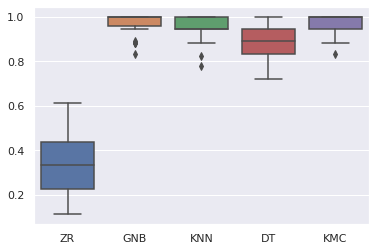

In [14]:
keys = all_scores.keys()
vals = list(all_scores.values())
# sns.boxplot(data=fix_data, whis=np.inf, width=.18)
sns.boxplot(data=vals)
plt.xticks(plt.xticks()[0], keys)
plt.savefig('./images/boxplot.png')
plt.show()